In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import seaborn as sns

sns.set_theme()
sns.set_palette('deep')

### Helper Functions

In [2]:
def categorize_age(age):
    if age < 30: 
        cat = '<30'
    elif age < 50:
        cat = '30-49'
    elif age < 70:
        cat = '50-69'
    elif age < 90:
        cat = '70-89'
    else: 
        cat = '>90'
    return cat

## Preparing the raw data

In [3]:
DATA_PATH = "../MIMIC-III/precomputed/all_hourly_data.h5"

In [4]:
# vitals labs data 
data_labs = pd.read_hdf(DATA_PATH, 'vitals_labs_mean')
data_labs.index = data_labs.index.droplevel(['hadm_id', 'icustay_id'])
data_labs.columns = data_labs.columns.droplevel('Aggregation Function')
data_labs = data_labs[['heart rate', 'systolic blood pressure', 'diastolic blood pressure', 'respiratory rate', 'oxygen saturation', 
                      'temperature', 'glucose', 'potassium', 'sodium', 'chloride', 'creatinine', 'blood urea nitrogen', 'bicarbonate']]

data_labs.shape

(2200954, 13)

In [5]:
# demographic data 
data_stats = pd.read_hdf(DATA_PATH, 'patients')
data_stats.index = data_stats.index.droplevel(['hadm_id', 'icustay_id']) # only one ID is necessary
data_stats = data_stats[['age', 'gender', 'admission_type', 'first_careunit', 'hospital_expire_flag']] # select only the features that we will use + the outcome
data_stats.loc[:,'age'] = data_stats['age'].apply(categorize_age) # categorize the age because all over 90 are obscured 

data_stats.shape

(34472, 5)

## Creating 3 Datasets

- Features to be used:
  - 4 static features from patients (age, gender, admission_type, first_careunit)
  - best possible features from vitals_labs for given sampling rate (drop mean blood pressure)  

Options:
1. 2h , 9 Features, 5 from vitals labs:
     - heart rate, systolic blood pressure, diastolic blood pressure, mean blood pressure, respiratory rate, oxygen saturation
2. 4h, 9 Features, 5 from vitals labs: 
      - heart rate, systolic blood pressure, diastolic blood pressure, mean blood pressure, respiratory rate, oxygen saturation
3. 6h, 10 Features, 6 from vitals labs:
     - heart rate, systolic blood pressure, diastolic blood pressure, mean blood pressure, respiratory rate, oxygen saturation, temperature
4. 12h, 17 Features, 13  from vitals labs:
     - heart rate, systolic blood pressure, diastolic blood pressure, mean blood pressure, respiratory rate, oxygen saturation, temperature, glucose, potassium, sodium, chloride, creatinine, blood urea nitrogen, bicarbonate
  
After consideration the 12h sampling rate results in too few timepoints per patient to be usefull for timeseries based prediction. On the other hand a dataset with 2h sampling rate matches the sampling rate on the Charité data and improves number of obs per patient


### 1. 2h sampling, 9 Features

In [23]:
# reduce sampling interval to 2h 
df2h = data_labs.loc[:,['heart rate', 'systolic blood pressure', 'diastolic blood pressure', 'respiratory rate', 'oxygen saturation'], ] # use only the 5 features 
df2h['2h'] = df2h.groupby(['subject_id']).cumcount()//2

# create new dataframe for 6h sampling rate
df2h = df2h.groupby(['subject_id', '2h']).mean() # group 2h together and take mean

# join in demographic data (same values are added for each timepoint)
df2h = df2h.join(data_stats)

# drop all patients with any missing value
df2h = df2h.groupby('subject_id').filter(lambda x: x.notna().all().all()) # filter groups where all elements in all columns are notna

In [24]:
df2h.groupby('subject_id').ngroups

3492

### 2. 4h sampling, 9 Features

In [25]:
# reduce sampling interval to 4h 
df4h = data_labs.loc[:,['heart rate', 'systolic blood pressure', 'diastolic blood pressure', 'respiratory rate', 'oxygen saturation'], ] # use only the 5 features 
df4h['4h'] = df4h.groupby(['subject_id']).cumcount()//4

# create new dataframe for 6h sampling rate
df4h = df4h.groupby(['subject_id', '4h']).mean() # group 4h together and take mean

# join in demographic data (same values are added for each timepoint)
df4h = df4h.join(data_stats)

# drop all patients with any missing value
df4h = df4h.groupby('subject_id').filter(lambda x: x.notna().all().all()) # filter groups where all elements in all columns are notna


In [26]:
# how many patients remain?
df4h.groupby('subject_id').ngroups

13397

### 3. 6h sampling, 10 Features

In [27]:
# reduce sampling interval to 6h 
df6h = data_labs.loc[:,['heart rate', 'systolic blood pressure', 'diastolic blood pressure', 'respiratory rate', 'oxygen saturation', 'temperature'], ] # use only 6 required features 
df6h['6h'] = df6h.groupby(['subject_id']).cumcount()//6

# create new dataframe for 6h sampling rate
df6h = df6h.groupby(['subject_id', '6h']).mean() # group 6h together and take mean

# join in demographic data (same values are added for each timepoint)
df6h = df6h.join(data_stats)

# drop all patients with any missing value
df6h = df6h.groupby('subject_id').filter(lambda x: x.notna().all().all()) # filter groups where all elements in all columns are notna


In [28]:
# how many patients remain?
df6h.groupby('subject_id').ngroups

9290

### Order the Categorical Features where possible

In [29]:
# order the categorical features where applicable
age_order = pd.CategoricalDtype(categories=['<30', '30-49', '50-69', '70-89', '>90'], ordered=True) # this will correspond to factors 0, 1, 2, 3, 4 after factorization
admission_order = pd.CategoricalDtype(categories=['ELECTIVE', 'URGENT', 'EMERGENCY'], ordered=True) # this will correspond to factors 0, 1, 2 after factorization

for df in [df2h, df4h, df6h]:
    # order the age and admission type features
    df['age'] = df['age'].astype(age_order)
    df['admission_type'] = df['admission_type'].astype(admission_order)

    # we can factorize the categorical features if needed:
    
    # df['age'] = df['age'].factorize(sort=True)[0]
    # df['admission_type'] = df['admission_type'].factorize(sort=True)[0]
    #gender cannot be ordered but can still be factorized as binary 0:M, 1:F
    # df['gender'] = df['gender'].factorize()[0]

# first care unit cannot be ordered and not factorized because there are too many categories which are not necessarily hiearchical

### Clean up Column Names
replace all spaces with _ to avoid future problems

In [6]:
df2h.columns = [col.replace(" ", "_") for col in df2h.columns]
df4h.columns = [col.replace(" ", "_") for col in df4h.columns]
df6h.columns = [col.replace(" ", "_") for col in df6h.columns]

## Save Datasets

In [8]:
# df2h.to_parquet('outdata/datasets/complete/data2h.parquet')
# df4h.to_parquet('outdata/datasets/complete/data4h.parquet')
# df6h.to_parquet('outdata/datasets/complete/data6h.parquet')

In [19]:
# reload for future analysis
df2h = pd.read_parquet('outdata/datasets/complete/data2h.parquet')
df4h = pd.read_parquet('outdata/datasets/complete/data4h.parquet')
df6h = pd.read_parquet('outdata/datasets/complete/data6h.parquet')

## Original data Distribution

Histograms of data without sampling rate reduction.


In [10]:
origdf = data_labs.loc[:,['heart rate', 'systolic blood pressure', 'diastolic blood pressure', 'respiratory rate', 'oxygen saturation'], ]
origdf = origdf.join(data_stats)
origdf.columns = [col.replace(" ", "_") for col in origdf.columns]

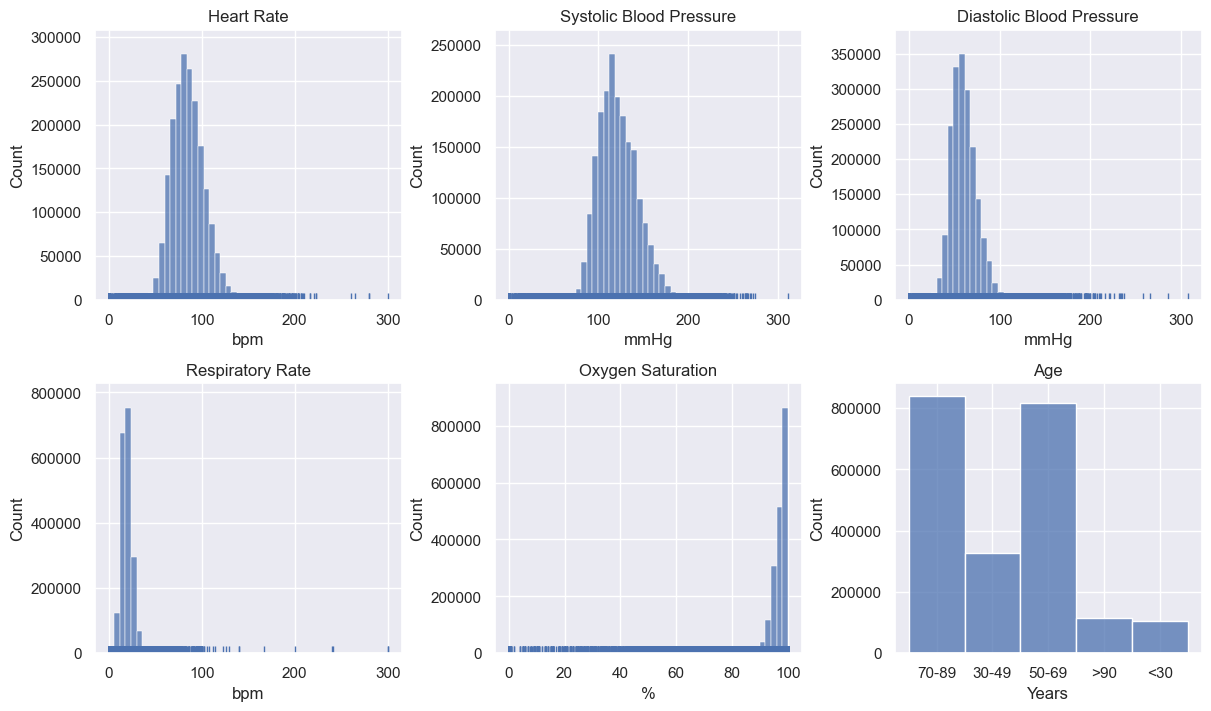

In [12]:
fig = plt.figure(constrained_layout=True, figsize=(12,7))

featno = 0

feats = ['heart_rate', 'systolic_blood_pressure', 'diastolic_blood_pressure', 'respiratory_rate', 'oxygen_saturation', ]
titles = ['Heart Rate', 'Systolic Blood Pressure', 'Diastolic Blood Pressure', 'Respiratory Rate', 'Oxygen Saturation', ]
units = ['bpm', 'mmHg', 'mmHg', 'bpm', '%']
ranges = [(0,200), (0,200),(0,200), (0,60),(85,100)]

feat = feats[featno]
title = titles[featno]
unit = units[featno]
yrange = ranges[featno]

# pal = sns.color_palette()
# newpal = pal[6:8] + pal[:6]

subf = fig.subfigures(2,1)
top = subf[0].subplots(1,3, sharex=False, sharey=False)
bot = subf[1].subplots(1,3, sharex=False, sharey=False)

axs = [top[0], top[1], top[2], bot[0], bot[1], ]

for n in range(5):
    sns.histplot(origdf[feats[n]], bins=50, ax=axs[n], kde=False )
    sns.rugplot(origdf[feats[n]],ax=axs[n])
    axs[n].set_title(titles[n])
    axs[n].set_xlabel(units[n])
    # axs[n].set_xlim(ranges[n])
    
# bot[2].axis('off')
sns.histplot(origdf['age'], bins='auto', ax=bot[2] )
bot[2].set_title('Age')
bot[2].set_xlabel('Years')
# axs[n].set_xlabel(units[n])


# plt.savefig('outdata/images/origfeatdistribution.pdf', bbox_inches='tight')  
plt.show()

And overlayed with histogram of 2h dataset:

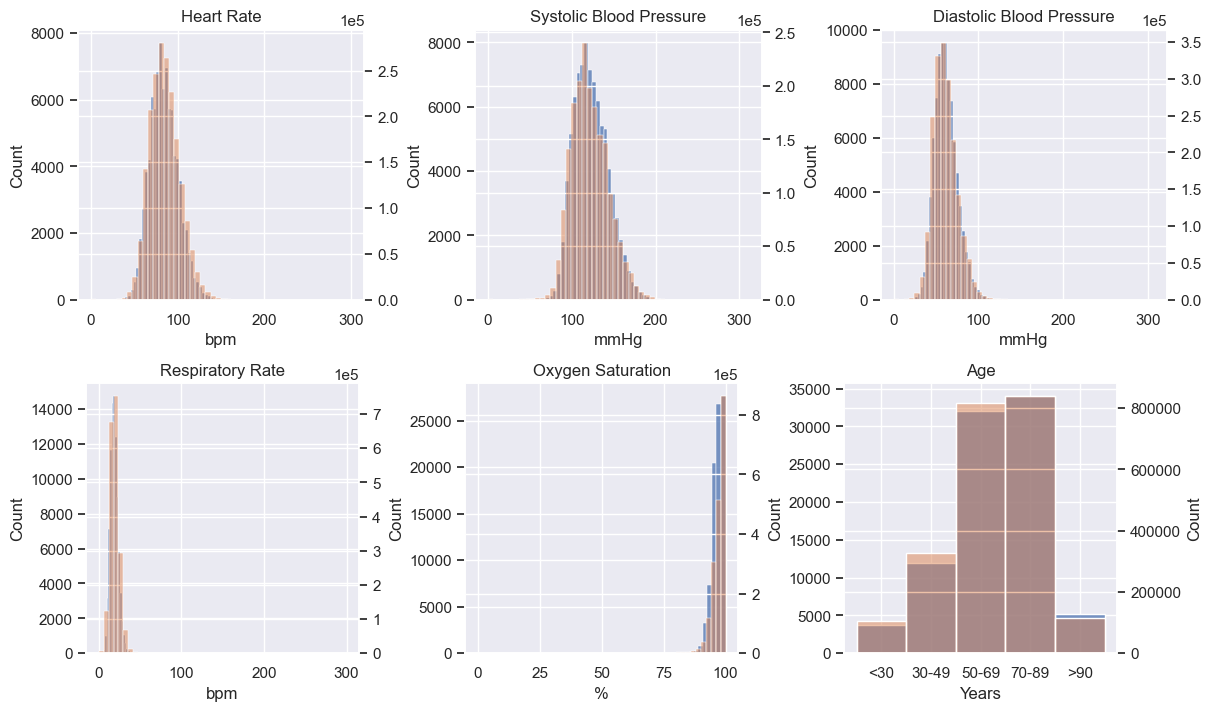

In [32]:
fig = plt.figure(constrained_layout=True, figsize=(12,7))

featno = 0

feats = ['heart_rate', 'systolic_blood_pressure', 'diastolic_blood_pressure', 'respiratory_rate', 'oxygen_saturation', ]
titles = ['Heart Rate', 'Systolic Blood Pressure', 'Diastolic Blood Pressure', 'Respiratory Rate', 'Oxygen Saturation', ]
units = ['bpm', 'mmHg', 'mmHg', 'bpm', '%']
ranges = [(0,200), (0,200),(0,200), (0,60),(85,100)]

feat = feats[featno]
title = titles[featno]
unit = units[featno]
yrange = ranges[featno]

# pal = sns.color_palette()
# newpal = pal[6:8] + pal[:6]

subf = fig.subfigures(2,1)
top = subf[0].subplots(1,3, sharex=False, sharey=False)
bot = subf[1].subplots(1,3, sharex=False, sharey=False)

axs = [top[0], top[1], top[2], bot[0], bot[1], ]
twins = [ax.twinx() for ax in axs]

for n in range(5):
    sns.histplot(df2h[feats[n]], bins=50, ax=axs[n], kde=False )
    sns.histplot(origdf[feats[n]], bins=50, ax=twins[n], kde=False, color=sns.color_palette()[1], alpha=0.5 )

    axs[n].set_title(titles[n])
    axs[n].set_xlabel(units[n])
    twins[n].set_ylabel('')
    twins[n].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

bot2twin=bot[2].twinx()
sns.histplot(df2h['age'], bins='auto', ax=bot[2] )
sns.histplot(origdf['age'], bins='auto', ax=bot2twin, color=sns.color_palette()[1], alpha=0.5  )
bot[2].set_title('Age')
bot[2].set_xlabel('Years')
# axs[n].set_xlabel(units[n])


# plt.savefig('outdata/images/compdistributioncompleteandgt.pdf', bbox_inches='tight')  
plt.show()